<a href="https://colab.research.google.com/github/phyml4e/PINNs/blob/main/Thermal/Thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**More information about this short introduction/code as well as the performance of some possible version of PINNs can be found in our paper:**

https://www.sciencedirect.com/science/article/abs/pii/S0045782522005722

http://arxiv.org/abs/2206.13103

**For more information about PINNs in general see:**

https://arxiv.org/abs/1711.10561

**For more information about SciAnn library see:**

https://arxiv.org/abs/2005.08803

**SciAnn** is a library for the performing Physics-Informed Neural Network. More info can be found at www.sciann.com.



In [1]:
# !pip install sciann -q

     |████████████████████████████████| 168 kB 2.1 MB/s 
     |████████████████████████████████| 561 kB 21.2 MB/s 


**Importing the necessary  libraries and functions.**

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sciann as sn
from sciann.utils.math import diff, sqrt, abs
import tensorflow as tf

---------------------- SCIANN 0.6.7.6 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.2 
Python Version: 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0] 



**Choosing parameters and hyper-parameters of the neural network.**

In [3]:
dtype     = 'float64'       # type of the input
n_of_n    = 5*[40]          # number of neurons (layers*[neurons])
act       = 'tanh'          # activation function ## different activation
                            # function can be used such as:
                            # "tanh", "softplus", "Relu", "sigmoid", "softmax" 
LR        = 0.001           # learning rate in adam optimizer ## reduce for getting better (but slower) convergence
Epochs    = 1000            # number of epochs ## increase for getting better accuracy
batch     = 2601            # batch size ## increase for getting better accuracy
Optimizer ='adam'           # other available optimizer in Keras 
                            # such as 'scipy-l-BFGS-B' , 'SGD'

In [4]:
x = sn.Variable('x', dtype=dtype)
y = sn.Variable('y', dtype=dtype)
E = sn.Variable('E', dtype=dtype)

T      = sn.Functional('T',     [x,y], n_of_n, act)
q_x_O  = sn.Functional('gT_x',  [x,y], n_of_n, act)
q_y_O  = sn.Functional('gT_y',  [x,y], n_of_n, act)

gr_T_x = diff(T, x)
gr_T_y = diff(T, y)
q_x    = (-E)*(gr_T_x)
q_y    = (-E)*(gr_T_y)

**Importing collocation points**

In [5]:
Load_data = np.loadtxt('https://raw.githubusercontent.com/phyml4e/PINNs/main/Thermal/CP.txt')

x1 = Load_data[:,2]
y1 = Load_data[:,3]
e1 = Load_data[:,4]

x_data = np.reshape(Load_data[:,2], (51,51))
y_data = np.reshape(Load_data[:,3], (51,51))
E_data = np.reshape(Load_data[:,4], (51,51))

In [6]:
result_FE = pd.read_csv('https://raw.githubusercontent.com/phyml4e/PINNs/main/Thermal/FE.csv')
T_FE =  pd.DataFrame(result_FE, columns= ['Displacements'])
q_x_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:12'])
q_y_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:13'])
grad_T_FE =  pd.DataFrame(result_FE, columns= ['Stress/Strain:15'])
T_FE = np.array(T_FE)
T_FE = np.reshape(T_FE, (51,51))
q_x_FE = np.array(q_x_FE)
q_x_FE = np.reshape(q_x_FE, (51,51))
q_y_FE = np.array(q_y_FE)
q_y_FE = np.reshape(q_y_FE, (51,51))
grad_T_FE = np.array(grad_T_FE)
grad_T_FE = np.reshape(grad_T_FE, (51,51))

**Adding the governing equations into loss function**

In [7]:
# weights for equations
w1 = 1
w11 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
wN = 1

In [8]:
def boundary_value_mask(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if x[i]==0 or x[i]==1 or y[i]==0 or y[i]==1:
            M[i] = 1
    return M

def boundary_value_mask_right(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if x[i]==1:
            M[i] = 1
    return M

def boundary_value_mask_left(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if x[i]==0:
            M[i] = 1
    return M

def boundary_value_mask_top(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if y[i]==1:
            M[i] = 1
    return M

def boundary_value_mask_bottom(x,y):
    M = np.zeros(x.shape)
    for i in range(len(x)):
        if y[i]==0:
            M[i] = 1
    return M

In [9]:
M_bound = boundary_value_mask(x1,y1)
M_bound_right = boundary_value_mask_right(x1,y1)
M_bound_left = boundary_value_mask_left(x1,y1)
M_bound_top = boundary_value_mask_top(x1,y1)
M_bound_bottom = boundary_value_mask_bottom(x1,y1)
M_domain = np.array((M_bound==0)*1.0)
nb = np.sum(M_bound)
nb_r = np.sum(M_bound_right)
nb_l = np.sum(M_bound_left)
nb_t = np.sum(M_bound_top)
nb_b = np.sum(M_bound_bottom)
nd = np.sum(M_domain)
M_bound_right = tf.convert_to_tensor(M_bound_right)
M_bound_left = tf.convert_to_tensor(M_bound_left)
M_bound_top = tf.convert_to_tensor(M_bound_top)
M_bound_bottom = tf.convert_to_tensor(M_bound_bottom)
M_domain = tf.convert_to_tensor(M_domain)

In [10]:
################# ENERGY 
Work_int = np.sum(M_domain*(q_x * gr_T_x + q_y * gr_T_y), axis=-1)/(2*nd)

Work_e_r = np.sum(M_bound_right*(q_x * T), axis=-1)/nb_r
Work_e_l = np.sum(M_bound_left*(-q_x * T), axis=-1)/nb_l
Work_e_t = np.sum(M_bound_top*(q_y * T), axis=-1)/nb_t
Work_e_b = np.sum(M_bound_bottom*(-q_y * T), axis=-1)/nb_b
Work_ext = Work_e_r + Work_e_l + Work_e_t + Work_e_b

Work = sn.PDE(sqrt(abs(w1*Work_int - w1*Work_ext)))

################# PDE
PDE1 = sn.PDE(w2*diff(q_x_O, x) + w2*diff(q_y_O, y))

################# CONECT
EQ1  = sn.PDE(w3*q_x_O  - w3*q_x)
EQ2  = sn.PDE(w3*q_y_O  - w3*q_y)

################# ENERGY II
#Work_int_O = np.sum(M_domain*(q_x_O * gr_T_x_O + q_y_O * gr_T_y_O), axis=-1)/(2*nd)
Work_int_O = np.sum(M_domain*(q_x_O * gr_T_x + q_y_O * gr_T_y), axis=-1)/(2*nd)

Work_e_O_r = np.sum(M_bound_right*(q_x_O * T), axis=-1)/nb_r
Work_e_O_l = np.sum(M_bound_left*(-q_x_O * T), axis=-1)/nb_l
Work_e_O_t = np.sum(M_bound_top*(q_y_O * T), axis=-1)/nb_t
Work_e_O_b = np.sum(M_bound_bottom*(-q_y_O * T), axis=-1)/nb_b
Work_ext_O = Work_e_O_r + Work_e_O_l + Work_e_O_t + Work_e_O_b

Work_O = sn.PDE(sqrt(abs(w11*Work_int_O - w11*Work_ext_O)))

In [11]:
################# BCs
BC1  = (x==0.)*(w4*T - w4*1.0)       #left
BC2  = (x==1.)*(w4*T)                #right temp

BC3  = (y==0.)*(w5*q_y)              #down q_y
BC4  = (y==0.)*(wN*q_y_O)            #down q_y

BC5 = (y==1.)*(w5*q_y)               #up q_y
BC6 = (y==1.)*(wN*q_y_O)             #up q_y

In [12]:
model = sn.SciModel([x, y, E], [Work, Work_O, PDE1, EQ1, EQ2, BC1, BC2, BC3, BC4, BC5, BC6], loss_func="mse")

In [13]:
input_data = [x1, y1, e1]
target_data = 11*['zeros']

**Training the network**

In [ ]:
history = model.train(input_data, target_data, learning_rate=LR, epochs=Epochs, batch_size=batch, verbose=0)

# Post processing

**History of loss function through epochs**

In [ ]:
loss_name = ['loss', 'Work', 'Work_O', 'PDE1', 'EQ1', 'EQ2', 'BC1', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6']
fig = plt.figure(figsize=(12, 7))
itter = 0 
for word, loss in history.history.items():
        if word.endswith("loss"):
            plt.semilogy(np.array(loss), label=loss_name[itter])
            itter+=1
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
fig = plt.figure(figsize=(12, 7))
plt.semilogy(history.history['loss'], label='Total_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Total-loss')

**Comparing the network prediction and FE results.**

In [14]:
# model.load_weights('model_v1_temperature.hdf5') # uncomment to show the result after 100k Epochs

In [15]:
T_pred     = T.eval(model, [x_data, y_data, E_data])
q_x_pred   = q_x.eval(model, [x_data, y_data, E_data])
q_y_pred   = q_y.eval(model, [x_data, y_data, E_data])
q_x_O_pred = q_x_O.eval(model, [x_data, y_data, E_data])
q_y_O_pred = q_y_O.eval(model, [x_data, y_data, E_data])
##### computing the errors 
T_error = np.abs(T_pred- T_FE)
q_x_error = np.abs(q_x_pred- q_x_FE)
q_y_error = np.abs(q_y_pred- q_y_FE)

([], [], [])

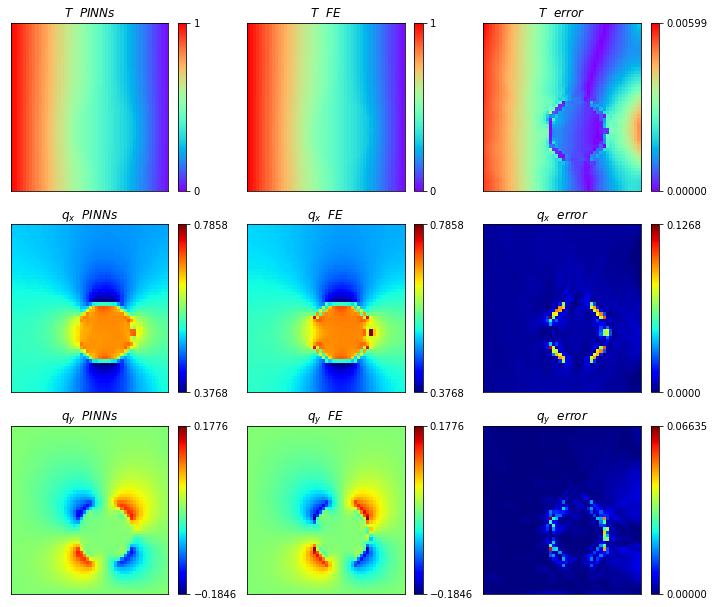

In [16]:
fig,ax = plt.subplots(3,3,figsize=(12,10.5))
plt.colorbar(ax[0,0].pcolor(x_data, y_data, T_pred, cmap='rainbow',vmin=T_FE.min(), vmax=T_FE.max(), linewidth=0,rasterized=True)
                            ,ax=ax[0,0], ticks=[T_FE.min(),T_FE.max()])
plt.colorbar(ax[0,1].pcolor(x_data, y_data, T_FE, cmap='rainbow',vmin=T_FE.min(), vmax=T_FE.max(), linewidth=0,rasterized=True) 
                            ,ax=ax[0,1], ticks=[T_FE.min(),T_FE.max()])
plt.colorbar(ax[0,2].pcolor(x_data, y_data, T_error, cmap='rainbow',vmin=T_error.min(), vmax=T_error.max(), linewidth=0,rasterized=True)
                            ,ax=ax[0,2], ticks=[T_error.min(),T_error.max()])

plt.colorbar(ax[1,0].pcolor(x_data, y_data, q_x_pred, cmap='jet', vmin=q_x_FE.min(), vmax=q_x_FE.max(), linewidth=0,rasterized=True)
                            ,ax=ax[1,0], ticks=[q_x_FE.min(),q_x_FE.max()])
plt.colorbar(ax[1,1].pcolor(x_data, y_data, q_x_FE, cmap='jet',vmin=q_x_FE.min(), vmax=q_x_FE.max(), linewidth=0,rasterized=True)
                            ,ax=ax[1,1], ticks=[q_x_FE.min(),q_x_FE.max()])
plt.colorbar(ax[1,2].pcolor(x_data, y_data, q_x_error, cmap='jet',vmin=q_x_error.min(), vmax=q_x_error.max(), linewidth=0,rasterized=True)
                            ,ax=ax[1,2], ticks=[q_x_error.min(),q_x_error.max()])

plt.colorbar(ax[2,0].pcolor(x_data, y_data, q_y_pred, cmap='jet',vmin=q_y_FE.min(), vmax=q_y_FE.max(),linewidth=0,rasterized=True)
                            ,ax=ax[2,0],ticks=[q_y_FE.min(),q_y_FE.max()])
plt.colorbar(ax[2,1].pcolor(x_data, y_data, q_y_FE, cmap='jet',vmin=q_y_FE.min(), vmax=q_y_FE.max(),linewidth=0,rasterized=True)
                            ,ax=ax[2,1],ticks=[q_y_FE.min(),q_y_FE.max()])
plt.colorbar(ax[2,2].pcolor(x_data, y_data, q_y_error, cmap='jet',vmin=q_y_error.min(), vmax=q_y_error.max(),linewidth=0,rasterized=True)
                            ,ax=ax[2,2],ticks=[q_y_error.min(),q_y_error.max()])

ax[0,0].set_title(r'$T \, \, \, \, PINNs$'),ax[0,1].set_title(r'$T \, \, \, \, FE$'),ax[0,2].set_title(r'$T \, \, \, \, error$')
ax[1,0].set_title(r'$q_x \, \, \, \, PINNs$'),ax[1,1].set_title(r'$q_x \, \, \, \, FE$'),ax[1,2].set_title(r'$q_x \, \, \, \, error$')
ax[2,0].set_title(r'$q_y \, \, \, \, PINNs$'),ax[2,1].set_title(r'$q_y \, \, \, \, FE$'),ax[2,2].set_title(r'$q_y \, \, \, \, error$')
ax[0,0].set_yticks([]), ax[0,1].set_yticks([]), ax[0,2].set_yticks([])
ax[1,0].set_yticks([]), ax[1,1].set_yticks([]), ax[1,2].set_yticks([])
ax[2,0].set_yticks([]), ax[2,1].set_yticks([]), ax[2,2].set_yticks([])
ax[0,0].set_xticks([]), ax[0,1].set_xticks([]), ax[0,2].set_xticks([])
ax[1,0].set_xticks([]), ax[1,1].set_xticks([]), ax[1,2].set_xticks([])
ax[2,0].set_xticks([]), ax[2,1].set_xticks([]), ax[2,2].set_xticks([])